# 3. Streaming application using Spark Structured Streaming

In [1]:
# Import all the required libraries
import os
# Set up the environment
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-streaming-kafka-0-10_2.12:3.0.0,org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.0 pyspark-shell'

from pyspark.sql.functions import *
from pyspark.sql.types import *

from pyspark.ml import PipelineModel

import datetime as dt
import time
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

# Import SparkConf, SparkSession and SparkContext classes for Spark Session setup and Spark SQL
from pyspark import SparkConf
from pyspark.sql import SparkSession # Spark SQL
from pyspark import SparkContext #Spark

 <div class = "alert alert-block alert-info">
1. SparkSession is created using a SparkConf object, which would use two local cores
with a proper application name, and use UTC as the timezone

In [2]:
# Run Spark in local mode with 2 processors as logical cores
master = 'local[2]'

# Set the name for Spark application
app_name = 'Streaming application for detecting Linux system hacking activities'

# Setup configuration parameters for Spark Session with UTC as the timezone
spark_conf = SparkConf().setMaster(master).setAppName(app_name).set('spark.sql.session.timeZone', 'UTC')

# Initialize Spark Session and create a SparkContext Object
spark = SparkSession.builder.config(conf = spark_conf).getOrCreate()

 <div class = 'alert alert-block alert-info'>
2. From the Kafka producers in Task 1.1 and 1.2, ingest the streaming data into Spark
Streaming for both process and memory activities

In [3]:
# Set the topic name and ingest the data using the respective parameters for the process events
process_topic = 'process_stream'
df_process = spark\
    .readStream\
    .format('kafka')\
    .option('kafka.bootstrap.servers', '127.0.0.1:9092')\
    .option('subscribe', process_topic)\
    .load()

# Set the topic name and ingest the data using the respective parameters for the memory events
memory_topic = 'memory_stream'
df_memory = spark\
    .readStream\
    .format('kafka')\
    .option('kafka.bootstrap.servers', '127.0.0.1:9092')\
    .option('subscribe', memory_topic)\
    .load()

### Perform the necessary data wrangling

 <div class = 'alert alert-block alert-info'>
Then the streaming data format should be transformed into the proper formats
following the metadata file schema for both process and memory, similar to
assignment 2A

In [4]:
# Cast both the streams' keys and values into string to initiate
df_process = df_process.selectExpr('CAST(key AS STRING)', 'CAST(value AS STRING)')
df_memory = df_memory.selectExpr('CAST(key AS STRING)', 'CAST(value AS STRING)')

In [5]:
# Define the schema for the process stream
# Defining all the attributes to be strings at the initiation for easy wrangling and interpretability
# Only the timestamp attribute is defined as an integer data type
processSchema = ArrayType(StructType([
    StructField('sequence', StringType(), True),
    StructField('machine', StringType(), True),
    StructField('PID', StringType(), True),
    StructField('TRUN', StringType(), True),
    StructField('TSLPI', StringType(), True),
    StructField('TSLPU', StringType(), True),
    StructField('POLI', StringType(), True),
    StructField('NICE', StringType(), True),
    StructField('PRI', StringType(), True),
    StructField('RTPR', StringType(), True),
    StructField('CPUNR', StringType(), True),
    StructField('Status', StringType(), True),
    StructField('EXC', StringType(), True),
    StructField('State', StringType(), True),
    StructField('CPU', StringType(), True),
    StructField('CMD', StringType(), True),
    StructField('ts', IntegerType(), True)
]))

# Define the schema for the memory stream
# Defining all the attributes to be strings at the initiation for easy wrangling and interpretability
# Only the timestamp attribute is defined as an integer data type
memorySchema = ArrayType(StructType([
    StructField('sequence', StringType(), True),
    StructField('machine', StringType(), True),
    StructField('PID', StringType(), True),
    StructField('MINFLT', StringType(), True),
    StructField('MAJFLT', StringType(), True),
    StructField('VSTEXT', StringType(), True),
    StructField('VSIZE', StringType(), True),
    StructField('RSIZE', StringType(), True),
    StructField('VGROW', StringType(), True),
    StructField('RGROW', StringType(), True),
    StructField('MEM', StringType(), True),
    StructField('CMD', StringType(), True),
    StructField('ts', IntegerType(), True),
]))

In [6]:
# Parse the values and pass them through the above defined schema for both the streams
df_process = df_process.select(from_json(col('value').cast('string'), processSchema).alias('parsed_value'))
df_memory = df_memory.select(from_json(col('value').cast('string'), memorySchema).alias('parsed_value'))

In [7]:
# Explode and map the key values correctly to return the correct rows of data for both the streams
df_process = df_process.select(explode(col('parsed_value')).alias('unnested_value'))
df_memory = df_memory.select(explode(col('parsed_value')).alias('unnested_value'))      

In [8]:
# Rename the columns correctly from the above parsed data for the process stream
df_process = df_process.select(
                    col('unnested_value.sequence').alias('sequence'),
                    col('unnested_value.machine').alias('machine'),
                    col('unnested_value.PID').alias('PID'),
                    col('unnested_value.TRUN').alias('TRUN'),
                    col('unnested_value.TSLPI').alias('TSLPI'),
                    col('unnested_value.TSLPU').alias('TSLPU'),
                    col('unnested_value.POLI').alias('POLI'),
                    col('unnested_value.NICE').alias('NICE'),
                    col('unnested_value.PRI').alias('PRI'),
                    col('unnested_value.RTPR').alias('RTPR'),
                    col('unnested_value.CPUNR').alias('CPUNR'),
                    col('unnested_value.Status').alias('Status'),
                    col('unnested_value.EXC').alias('EXC'),
                    col('unnested_value.State').alias('State'),
                    col('unnested_value.CPU').alias('CPU'),
                    col('unnested_value.CMD').alias('CMD'),
                    col('unnested_value.ts').alias('ts'))

# Rename the columns correctly from the above parsed data for the memory stream
df_memory = df_memory.select(
                    col('unnested_value.sequence').alias('sequence'),
                    col('unnested_value.machine').alias('machine'),
                    col('unnested_value.PID').alias('PID'),
                    col('unnested_value.MINFLT').alias('MINFLT'),
                    col('unnested_value.MAJFLT').alias('MAJFLT'),
                    col('unnested_value.VSTEXT').alias('VSTEXT'),
                    col('unnested_value.VSIZE').alias('VSIZE'),
                    col('unnested_value.RSIZE').alias('RSIZE'),
                    col('unnested_value.VGROW').alias('VGROW'),
                    col('unnested_value.RGROW').alias('RGROW'),
                    col('unnested_value.MEM').alias('MEM'),
                    col('unnested_value.CMD').alias('CMD'),
                    col('unnested_value.ts').alias('ts'))

 <div class = 'alert alert-block alert-info'>
The numeric values with extra spaces or “K” / “M” / “G” should be properly
transformed into their correct values

In [9]:
# Select the columns which need to be transformed for the above mentioned case
columns = ['MINFLT', 'MAJFLT', 'VSTEXT', 'RSIZE', 'VGROW', 'RGROW']

# Set a loop for the above selected columns to clean the data in the memory stream using regex
for column in columns:
    df_memory = df_memory.withColumn(column, regexp_replace(column, ' ', ''))
    df_memory = df_memory.withColumn(column, regexp_replace(column, '.K', '00'))
    df_memory = df_memory.withColumn(column, regexp_replace(column, 'K', '000'))
    df_memory = df_memory.withColumn(column, regexp_replace(column, '.M', '00000'))
    df_memory = df_memory.withColumn(column, regexp_replace(column, 'M', '000000'))

In [10]:
# Now cast and change the data types to the actual required ones for all the attributes respectively for the process stream
df_process = df_process.withColumn('sequence', df_process['sequence'].cast(IntegerType()))\
                    .withColumn('machine', df_process['machine'].cast(IntegerType()))\
                    .withColumn('PID', df_process['PID'].cast(IntegerType()))\
                    .withColumn('TRUN', df_process['TRUN'].cast(IntegerType()))\
                    .withColumn('TSLPI', df_process['TSLPI'].cast(IntegerType()))\
                    .withColumn('TSLPU', df_process['TSLPU'].cast(IntegerType()))\
                    .withColumn('NICE', df_process['NICE'].cast(IntegerType()))\
                    .withColumn('PRI', df_process['PRI'].cast(IntegerType()))\
                    .withColumn('RTPR', df_process['RTPR'].cast(IntegerType()))\
                    .withColumn('CPUNR', df_process['CPUNR'].cast(IntegerType()))\
                    .withColumn('EXC', df_process['EXC'].cast(IntegerType()))\
                    .withColumn('CPU', df_process['CPU'].cast(DoubleType()))

# Now cast and change the data types to the actual required ones for all the attributes respectively for the memory stream
df_memory = df_memory.withColumn('sequence', df_memory['sequence'].cast(IntegerType()))\
                    .withColumn('machine', df_memory['machine'].cast(IntegerType()))\
                    .withColumn('PID', df_memory['PID'].cast(IntegerType()))\
                    .withColumn('MINFLT', df_memory['MINFLT'].cast(IntegerType()))\
                    .withColumn('MAJFLT', df_memory['MAJFLT'].cast(IntegerType()))\
                    .withColumn('VSTEXT', df_memory['VSTEXT'].cast(IntegerType()))\
                    .withColumn('VSIZE', df_memory['VSIZE'].cast(DoubleType()))\
                    .withColumn('RSIZE', df_memory['RSIZE'].cast(DoubleType()))\
                    .withColumn('VGROW', df_memory['VGROW'].cast(DoubleType()))\
                    .withColumn('RGROW', df_memory['RGROW'].cast(DoubleType()))\
                    .withColumn('MEM', df_memory['MEM'].cast(DoubleType()))

In [11]:
df_process.printSchema()

root
 |-- sequence: integer (nullable = true)
 |-- machine: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- TRUN: integer (nullable = true)
 |-- TSLPI: integer (nullable = true)
 |-- TSLPU: integer (nullable = true)
 |-- POLI: string (nullable = true)
 |-- NICE: integer (nullable = true)
 |-- PRI: integer (nullable = true)
 |-- RTPR: integer (nullable = true)
 |-- CPUNR: integer (nullable = true)
 |-- Status: string (nullable = true)
 |-- EXC: integer (nullable = true)
 |-- State: string (nullable = true)
 |-- CPU: double (nullable = true)
 |-- CMD: string (nullable = true)
 |-- ts: integer (nullable = true)



In [12]:
df_memory.printSchema()

root
 |-- sequence: integer (nullable = true)
 |-- machine: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- MINFLT: integer (nullable = true)
 |-- MAJFLT: integer (nullable = true)
 |-- VSTEXT: integer (nullable = true)
 |-- VSIZE: double (nullable = true)
 |-- RSIZE: double (nullable = true)
 |-- VGROW: double (nullable = true)
 |-- RGROW: double (nullable = true)
 |-- MEM: double (nullable = true)
 |-- CMD: string (nullable = true)
 |-- ts: integer (nullable = true)



 <div class = 'alert alert-block alert-info'>
The NICE value should also be restored based on the PRI values using their
relationship

In [13]:
# Clean the data in NICE column based on the requirement of PRI column
# Only the available values of PRI in the data have been considered

# Create a new column for the refined values of NICE column
new_column = when(df_process.PRI == 100, -20)\
            .when(df_process.PRI == 109, -11)\
            .when(df_process.PRI == 121, 1)\
            .when(df_process.PRI == 130, 10)\
            .when(df_process.PRI == 139, 19)\
            .otherwise(0)

# Drop the previous unclean NICE column and append the new column as the new NICE column
df_process = df_process.drop('NICE').withColumn('NICE', new_column)\
            .select('sequence', 'machine', 'PID', 'TRUN', 'TSLPI', 'TSLPU', 'POLI', 'NICE',
                    'PRI', 'RTPR', 'CPUNR', 'Status', 'EXC', 'State', 'CPU', 'CMD', 'ts')

 <div class = 'alert alert-block alert-info'>
4. For process and memory, respectively, create a new column “CMD_PID”
concatenating “CMD” and “PID” columns, and a new column “event_time” as
timestamp format based on the unix time in “ts” column

In [14]:
# Concatenate the 'CMD' and 'PID' column values to create a new column for them for both the streams
df_process = df_process.withColumn('CMD_PID', concat(col('CMD'), lit('_'), col('PID')))
df_memory = df_memory.withColumn('CMD_PID', concat(col('CMD'), lit('_'), col('PID')))

In [15]:
# Create a new duplicate column of 'ts' for the process stream
df_process = df_process.withColumn('event_time', df_process['ts'])
# Change the data type of the new column to timestamp type
df_process = df_process.withColumn('event_time', from_utc_timestamp(from_unixtime(df_process['event_time']), 'UTC'))
# Allow a 20-second tolerance for possible data delay using the watermarking concept
df_process = df_process.withWatermark('event_time', '20 seconds')

# Create a new duplicate column of 'ts' for the memory stream
df_memory = df_memory.withColumn('event_time', df_memory['ts'])
# Change the data type of the new column to timestamp type
df_memory = df_memory.withColumn('event_time', from_utc_timestamp(from_unixtime(df_memory['event_time']), 'UTC'))
# Allow a 20-second tolerance for possible data delay using the watermarking concept
df_memory = df_memory.withWatermark('event_time', '20 seconds')

 <div class = 'alert alert-block alert-info'>
5. Persist the transformed streaming data in parquet format for both process and
memory

In [16]:
# Write the process stream into parquet files using the appropriate checkpoint location
query_file_sink_process = df_process.writeStream.format('parquet')\
                                    .outputMode('append')\
                                    .option('path', 'process.parquet')\
                                    .option('checkpointLocation', 'process.parquet/checkpoint')\
                                    .start()

# Write the memory stream into parquet files using the appropriate checkpoint location
query_file_sink_memory = df_memory.writeStream.format('parquet')\
                                    .outputMode('append')\
                                    .option('path', 'memory.parquet')\
                                    .option('checkpointLocation', 'memory.parquet/checkpoint')\
                                    .start()

In [17]:
# # Uncomment the following code if you wish to stop the above write streams
# query_file_sink_process.stop()
# query_file_sink_memory.stop()

 <div class = 'alert alert-block alert-info'>
6. Load the machine learning models given, and use the models to predict whether
each process or memory streaming record is an attack event, respectively

In [18]:
# # Uncomment the following code to unzip the zipped model files if not done already
# with zipfile.ZipFile('data_and_models/process_pipeline_model.zip', 'r') as zip_ref:
#     zip_ref.extractall()
    
# with zipfile.ZipFile('data_and_models/memory_pipeline_model.zip', 'r') as zip_ref:
#     zip_ref.extractall()

# Load the Pipeline models for both the streams from the filesystem
pipelineModel_process = PipelineModel.load('data_and_models/process_pipeline_model')
pipelineModel_memory = PipelineModel.load('data_and_models/memory_pipeline_model')

In [19]:
# Use the Pipeline models to make attack predictions on both the streams
pipelinePreds_process = pipelineModel_process.transform(df_process)
pipelinePreds_memory = pipelineModel_memory.transform(df_memory)

 <div class = 'alert alert-block alert-info'>
7a. If any program in one machine is predicted as an attack in EITHER process
or memory activity prediction, it could be a false alarm or a potential attack.
Keep track of the approximate count of such events in every 2-min window
for each machine for process and memory, respectively, and write the stream
into Spark Memory sink using complete mode

In [20]:
# Filter the data only for the attack predicted rows for both the streams
monitor_process = pipelinePreds_process.filter(col('prediction') == 1.0)
monitor_memory = pipelinePreds_memory.filter(col('prediction') == 1.0)

In [21]:
# Create a window for 119 seconds based on the given requirement and get the respective counts for the process stream
window_process = monitor_process.groupBy('machine', window(monitor_process.event_time, '119 seconds'))\
                                .agg(approx_count_distinct('CMD_PID').alias('count')).sort('machine')

# Create a window for 119 seconds based on the given requirement and get the respective counts for the memory stream
window_memory = monitor_memory.groupBy('machine', window(monitor_memory.event_time, '119 seconds'))\
                                .agg(approx_count_distinct('CMD_PID').alias('count')).sort('machine')

In [22]:
# Write the process stream output to the Spark Memory Sink using complete mode
memory_sink_process = window_process\
                        .writeStream\
                        .outputMode('complete')\
                        .format('memory')\
                        .queryName('ms_process')\
                        .start()

# Write the memory stream output to the Spark Memory Sink using complete mode
memory_sink_memory = window_memory\
                        .writeStream\
                        .outputMode('complete')\
                        .format('memory')\
                        .queryName('ms_memory')\
                        .start()

In [23]:
# # Uncomment the following code if you wish to stop the above write streams
# memory_sink_process.stop()
# memory_sink_memory.stop()

 <div class = 'alert alert-block alert-info'>
7b. If a program in one machine, having the same “CMD” and “PID” in both
process and memory streaming data, is predicted as an attack in BOTH
process and memory activity prediction, then this is considered as an attack
event. Find the streaming events fulfilling the criteria, create a new column to
record the processing time and persist them in parquet

In [24]:
# Rename the columns in the process stream which are required for joining both the streams
process_join = monitor_process.withColumnRenamed('CMD_PID', 'CMD_PID_process')\
                            .withColumnRenamed('machine', 'machine_process')\
                            .withColumnRenamed('ts', 'ts_process')\
                            .withColumnRenamed('event_time', 'event_time_process')\
                            .withColumnRenamed('prediction', 'prediction_process')\
                            .withColumnRenamed('sequence', 'sequence_process')

# Rename the columns in the memory stream which are required for joining both the streams
memory_join = monitor_memory.withColumnRenamed('ts', 'ts_memory')\
                            .withColumnRenamed('event_time', 'event_time_memory')\
                            .withColumnRenamed('sequence', 'sequence_memory')

# The above steps make it easy for the joining process and selection of the columns ahead

In [25]:
# Join the 2 streams based on the common 'CMD', 'PID' and 'machine' columns
process_memory_attack = process_join.join(memory_join,
                                          expr('''
                                                  CMD_PID_process = CMD_PID
                                                  AND machine_process = machine
                                               '''),
                                          'inner')

# Filter the data considering the difference between the 2 streams' event times is less than 30 seconds
process_memory_attack = process_memory_attack.withColumn('time_diff',
                                                         abs(col('ts_process') - col('ts_memory')))
process_memory_attack = process_memory_attack.filter(col('time_diff') < 30)

In [26]:
# Create a new column for adding the processing time to the data
process_memory_attack = process_memory_attack.withColumn('processing_time', current_timestamp())

 <div class = 'alert alert-block alert-info'>
Persist the program’s relevant information (including process &
memory data, process & memory’s event and processing timestamp,
and prediction result) into parquet format with the name of
“process_memory_attack.parquet

In [27]:
# Select the columns from the data based on the requirements
process_memory_attack = process_memory_attack.select('machine',
                                                     'CMD_PID',
                                                     'sequence_process',
                                                     'ts_process',
                                                     'TRUN',
                                                     'TSLPI',
                                                     'TSLPU',
                                                     'POLI',
                                                     'NICE',
                                                     'PRI',
                                                     'RTPR',
                                                     'CPUNR',
                                                     'Status',
                                                     'EXC',
                                                     'State',
                                                     'CPU',
                                                     'sequence_memory',
                                                     'ts_memory',
                                                     'MINFLT',
                                                     'MAJFLT',
                                                     'VSTEXT',
                                                     'VSIZE',
                                                     'RSIZE',
                                                     'VGROW',
                                                     'RGROW',
                                                     'MEM',
                                                     'event_time_process',
                                                     'event_time_memory',
                                                     'processing_time',
                                                     'prediction')

In [28]:
# Write the process stream into parquet files using the appropriate checkpoint location
query_file_sink_joined = process_memory_attack.writeStream.format('parquet')\
                                .outputMode('append')\
                                .option('path', 'process_memory_attack.parquet')\
                                .option('checkpointLocation', 'process_memory_attack.parquet/checkpoint')\
                                .start()

In [29]:
# # Uncomment the following code if you wish to stop the above write stream
# query_file_sink_joined.stop()

 <div class = 'alert alert-block alert-info'>
8. Visualise the data in line charts for step 7a<br><br>
For the count of suspect attacks for each machine in step 7a, use Spark SQL
to query the data from Spark Memory sink, and prepare a line chart plot for
showing the count of suspect attacks for each machine at each 2-min window
from the start to the most recent, and refresh the plot every 10 minutes

In [30]:
# Define a function to plot the visualisation graph
def init_plots():
    try:
        width = 12
        height = 8
        fig = plt.figure(figsize = (width, height)) # create new figure
        fig.subplots_adjust(hspace = 0.8)
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))

<IPython.core.display.Javascript object>


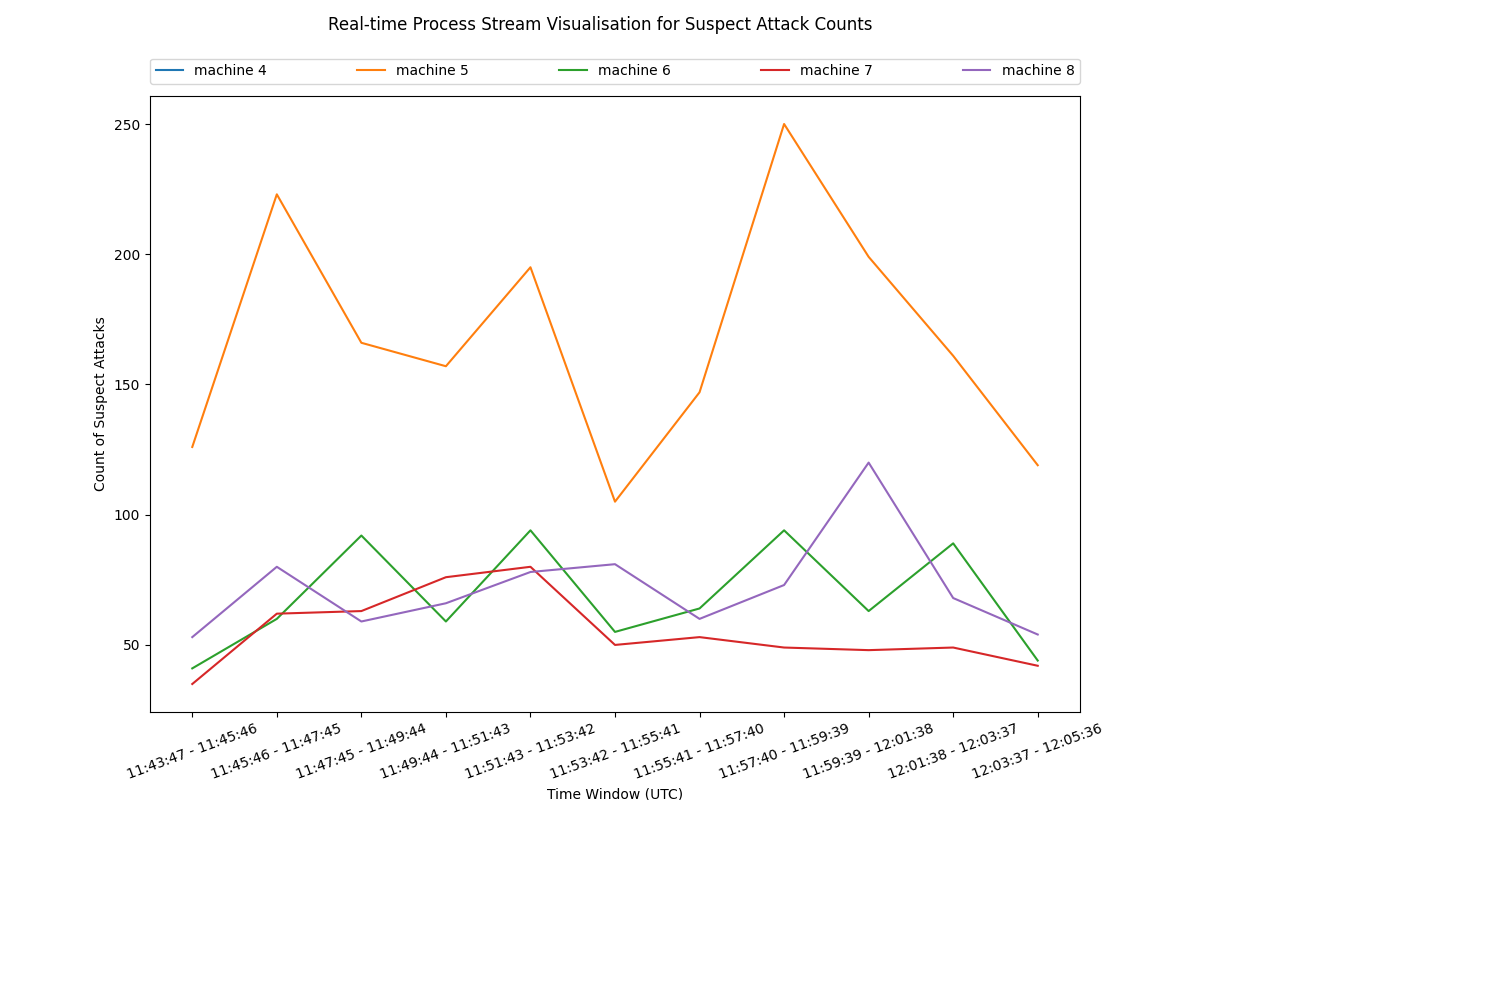

<IPython.core.display.Javascript object>


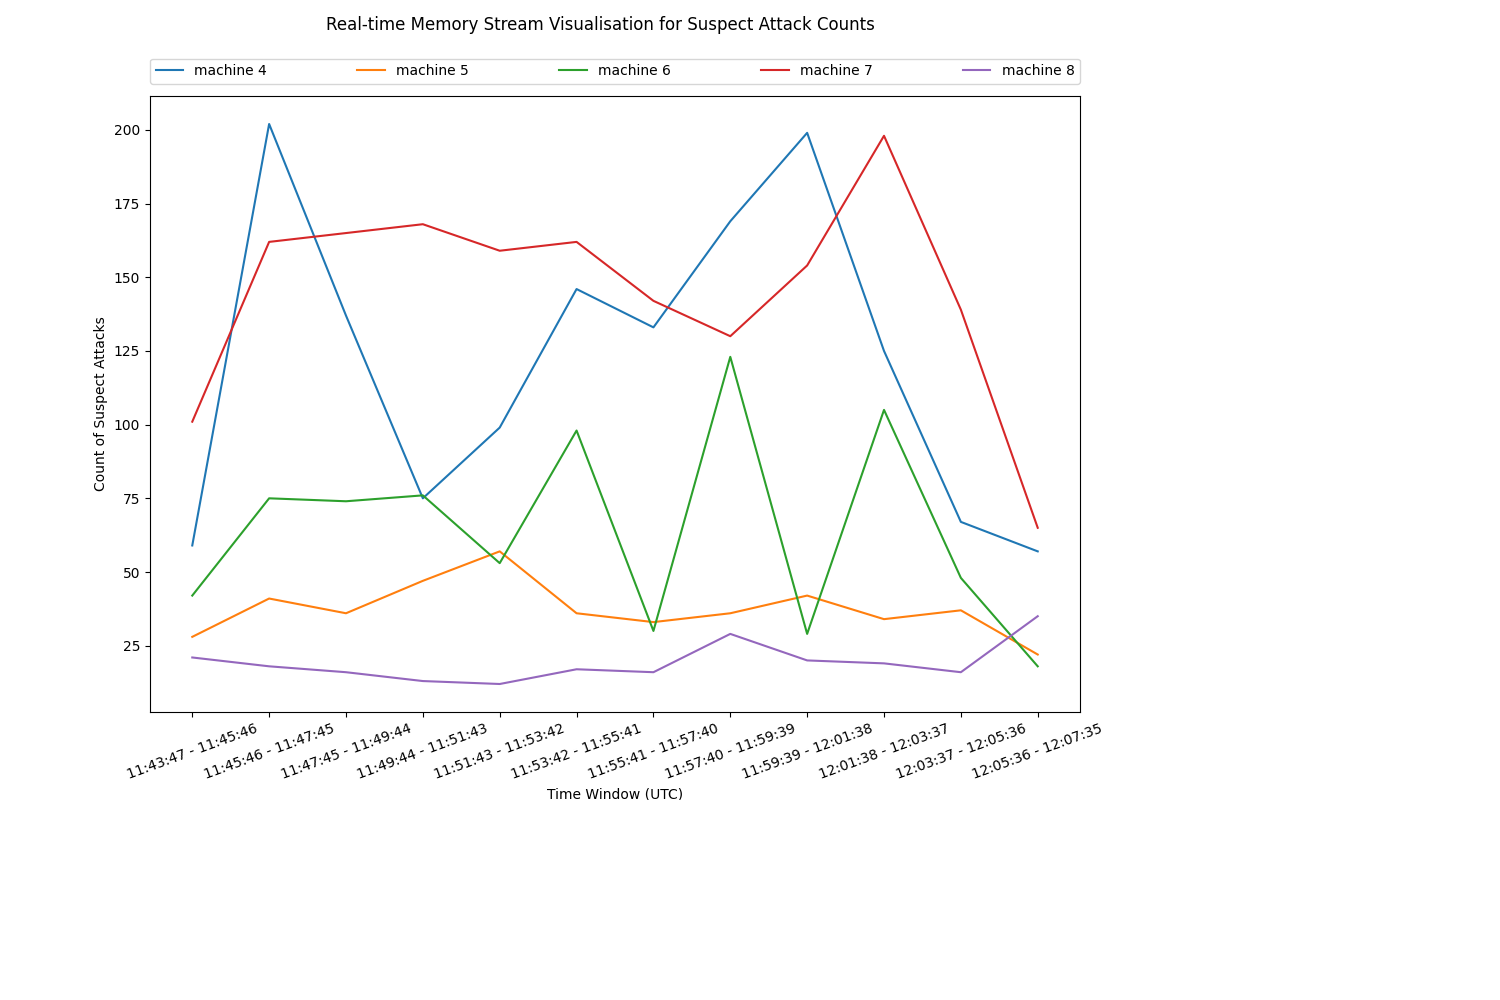

<ipython-input-31-92c00c2087a4>:20: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_process['window_start'] = pd.Series([val.time() for val in df_process['window_start']])
<ipython-input-31-92c00c2087a4>:23: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_process['window_end'] = pd.Series([val.time() for val in df_process['window_end']])
<ipython-input-31-92c00c2087a4>:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_memory['window_start'] = pd.Series([val.time() for val in df_memory['window_start']])
<ipython-input-31-92c00c2087a4>:32: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'f

KeyboardInterrupt: 

In [31]:
# Initiate the plots
fig1, ax1 = init_plots()
fig2, ax2 = init_plots()

while True:
    # Get the both the streams stored in the memory sink as pandas dataframes
    df_process = spark.sql('''
                              SELECT window.start AS window_start, window.end AS window_end, machine, count
                              FROM ms_process
                              ORDER BY window_end
                           ''').toPandas()

    df_memory = spark.sql('''
                             SELECT window.start AS window_start, window.end AS window_end, machine, count
                             FROM ms_memory
                             ORDER BY window_end
                          ''').toPandas()
    
    # Get the window start time for the process stream
    df_process['window_start'] = pd.Series([val.time() for val in df_process['window_start']])
    df_process['window_start'] = df_process['window_start'].astype(str)
    # Get the window end time for the process stream
    df_process['window_end'] = pd.Series([val.time() for val in df_process['window_end']])
    df_process['window_end'] = df_process['window_end'].astype(str)
    # Create a new column to concatenate the window start and end values
    df_process['window_concat'] = df_process['window_start'] + ' - ' + df_process['window_end']
    
    # Get the window start time for the memory stream
    df_memory['window_start'] = pd.Series([val.time() for val in df_memory['window_start']])
    df_memory['window_start'] = df_memory['window_start'].astype(str)
    # Get the window end time for the memory stream
    df_memory['window_end'] = pd.Series([val.time() for val in df_memory['window_end']])
    df_memory['window_end'] = df_memory['window_end'].astype(str)
    # Create a new column to concatenate the window start and end values
    df_memory['window_concat'] = df_memory['window_start'] + ' - ' + df_memory['window_end']

    # Filter out the dataframes for each respective machines for the process stream
    df_process_4 = df_process[df_process['machine'] == 4]
    df_process_5 = df_process[df_process['machine'] == 5]
    df_process_6 = df_process[df_process['machine'] == 6]
    df_process_7 = df_process[df_process['machine'] == 7]
    df_process_8 = df_process[df_process['machine'] == 8]
    
    # Filter out the dataframes for each respective machines for the memory stream
    df_memory_4 = df_memory[df_memory['machine'] == 4]
    df_memory_5 = df_memory[df_memory['machine'] == 5]
    df_memory_6 = df_memory[df_memory['machine'] == 6]
    df_memory_7 = df_memory[df_memory['machine'] == 7]
    df_memory_8 = df_memory[df_memory['machine'] == 8]
    
    # Create machine respective lists of the time windows for the process stream
    x4_process = df_process_4['window_concat'].to_list()
    x5_process = df_process_5['window_concat'].to_list()
    x6_process = df_process_6['window_concat'].to_list()
    x7_process = df_process_7['window_concat'].to_list()
    x8_process = df_process_8['window_concat'].to_list()
    # Create machine respective lists of the suspect attack counts for the process stream
    y4_process = df_process_4['count'].to_list()
    y5_process = df_process_5['count'].to_list()
    y6_process = df_process_6['count'].to_list()
    y7_process = df_process_7['count'].to_list()
    y8_process = df_process_8['count'].to_list()
    
    # Create machine respective lists of the time windows for the memory stream
    x4_memory = df_memory_4['window_concat'].to_list()
    x5_memory = df_memory_5['window_concat'].to_list()
    x6_memory = df_memory_6['window_concat'].to_list()
    x7_memory = df_memory_7['window_concat'].to_list()
    x8_memory = df_memory_8['window_concat'].to_list()
    # Create machine respective lists of the suspect attack counts for the memory stream
    y4_memory = df_memory_4['count'].to_list()
    y5_memory = df_memory_5['count'].to_list()
    y6_memory = df_memory_6['count'].to_list()
    y7_memory = df_memory_7['count'].to_list()
    y8_memory = df_memory_8['count'].to_list()
    
    # Plot the first graph for the process stream
    ax1.clear()
    ax1.plot(x4_process, y4_process, label = 'machine 4')
    ax1.plot(x5_process, y5_process, label = 'machine 5')
    ax1.plot(x6_process, y6_process, label = 'machine 6')
    ax1.plot(x7_process, y7_process, label = 'machine 7')
    ax1.plot(x8_process, y8_process, label = 'machine 8')
    ax1.set_xlabel('Time Window (UTC)')
    ax1.set_ylabel('Count of Suspect Attacks')
    ax1.tick_params(axis = 'x', labelrotation = 20)
    # Define a legend to the plot
    ax1.legend(bbox_to_anchor = (0., 1.02, 1., .102), loc = 'lower left',
               ncol = 5, mode = 'expand', borderaxespad = 0.)
    fig1.suptitle('Real-time Process Stream Visualisation for Suspect Attack Counts')
    fig1.canvas.draw()
    
    # Plot the second graph for the memory stream
    ax2.clear()
    ax2.plot(x4_memory, y4_memory, label = 'machine 4')
    ax2.plot(x5_memory, y5_memory, label = 'machine 5')
    ax2.plot(x6_memory, y6_memory, label = 'machine 6')
    ax2.plot(x7_memory, y7_memory, label = 'machine 7')
    ax2.plot(x8_memory, y8_memory, label = 'machine 8')
    ax2.set_xlabel('Time Window (UTC)')
    ax2.set_ylabel('Count of Suspect Attacks')
    ax2.tick_params(axis = 'x', labelrotation = 20)
    # Define a legend to the plot
    ax2.legend(bbox_to_anchor = (0., 1.02, 1., .102), loc = 'lower left',
               ncol = 5, mode = 'expand', borderaxespad = 0.)
    fig2.suptitle('Real-time Memory Stream Visualisation for Suspect Attack Counts')
    fig2.canvas.draw()
    
    # Add a delay of 10 minutes to refresh the graphs every 10 minutes
    time.sleep(600)